# K Nearest Neighbors classification walkthrough

In this notebook we are going to look at how the kNN algorithm classifies malignant vs. benign tumor category in the Wisconsin breast cancer dataset.

---

## kNN

The pseudocode algorithm for kNN is as follows:

```
for unclassified_point in sample:
    for known_point in known_class_points:
        calculate distances (euclidean or other) between known_point and unclassified_point
    for k in range of specified_neighbors_number:
        find k_nearest_points in known_class_points to unclassified_point
    assign class to unclassified_point using "votes" from k_nearest_points
```

---

[NOTE: in the case of ties, sklearn's `KNeighborsClassifier()` will just choose the first class using uniform weights! If this is unappealing to you you can change the weights keyword argument to 'distance'.]

---

### 1. Import necessary packages:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.neighbors import KNeighborsClassifier

In [2]:
import imp
plotter = imp.load_source('plotter', '/Users/kiefer/github-repos/DSI-SF-2/utils/plotting/knn_plotter.py')
from plotter import KNNBoundaryPlotter

---

### 2. Load in the dataset

My path, for example, below: is provided.

(The file as suffix '.data' but is actually formatted as a .csv)

In [3]:
bcw = pd.read_csv('/Users/kiefer/github-repos/DSI-SF-2/datasets/breast_cance_wisconsin/wdbc.data', 
                  header=None, index_col=None)

---

### 2.2 Renaming the columns

The attributes below will be the columns of the dataset.

      Attribute                     
   --------------------------------------------
   1. Sample code number [subject ID]
   2. Class
   3. Cell nucleus mean radius
   4. Cell nucleus SE radius
   5. Cell nucleus worst radius
   6. Texture mean
   7. Texture SE
   8. Texture worst
   9. Perimeter mean
   10. Perimeter SE
   11. Perimeter worst
   12. Area mean
   13. Area SE
   14. Area worst
   15. Smoothness mean
   16. Smoothness SE
   17. Smoothness worst
   18. Compactness mean
   19. Compactness SE
   20. Compactness worst
   21. Concavity mean
   22. Concavity SE
   23. Concavity worst
   24. Concave points mean
   25. Concave points SE
   26. Concave points worst
   27. Symmetry mean
   28. Symmetry SE
   29. Symmetry worst
   30. Fractal dimension mean
   31. Fractal dimension SE
   32. Fractal dimension worst

The column names are taken from the dataset info file. 

For more information check out the information file:

`../assets/datasets/wdbc.names`

You can open it with a text editor of your choice.

Create an array with the column names and assign them as the header when loading the csv.

In [4]:
column_names = ['id','malignant',
                'nucleus_mean','nucleus_se','nucleus_worst',
                'texture_mean','texture_se','texture_worst',
                'perimeter_mean','perimeter_se','perimeter_worst',
                'area_mean','area_se','area_worst',
                'smoothness_mean','smoothness_se','smoothness_worst',
                'compactness_mean','compactness_se','compactness_worst',
                'concavity_mean','concavity_se','concavity_worst',
                'concave_pts_mean','concave_pts_se','concave_pts_worst',
                'symmetry_mean','symmetry_se','symmetry_worst',
                'fractal_dim_mean','fractal_dim_se','fractal_dim_worst']

bcw.columns = column_names

---

### 2.3 Check out the dataset information

Print out the head and the datatypes.

In [5]:
bcw.head()

,id,malignant,nucleus_mean,nucleus_se,nucleus_worst,texture_mean,texture_se,texture_worst,perimeter_mean,perimeter_se,...,concavity_worst,concave_pts_mean,concave_pts_se,concave_pts_worst,symmetry_mean,symmetry_se,symmetry_worst,fractal_dim_mean,fractal_dim_se,fractal_dim_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
bcw.dtypes

id                     int64
malignant             object
nucleus_mean         float64
nucleus_se           float64
nucleus_worst        float64
texture_mean         float64
texture_se           float64
texture_worst        float64
perimeter_mean       float64
perimeter_se         float64
perimeter_worst      float64
area_mean            float64
area_se              float64
area_worst           float64
smoothness_mean      float64
smoothness_se        float64
smoothness_worst     float64
compactness_mean     float64
compactness_se       float64
compactness_worst    float64
concavity_mean       float64
concavity_se         float64
concavity_worst      float64
concave_pts_mean     float64
concave_pts_se       float64
concave_pts_worst    float64
symmetry_mean        float64
symmetry_se          float64
symmetry_worst       float64
fractal_dim_mean     float64
fractal_dim_se       float64
fractal_dim_worst    float64
dtype: object

---

### 2.4 Recode the class variable to be 0 vs. 1

The "malignant" class target variable is coded as "B" for benign and "M" as malignant. 

We need to recode this to a binary integer for classification, with "1" as malign and "0" as benign (malign is assigned to 1 because our goal is to predict malign tumors with the data).

In [7]:
bcw['malignant'] = bcw['malignant'].map(lambda x: 0 if x == "B" else 1)

In [8]:
print bcw.malignant.dtype

int64


---

### 3. Break up the data and look at correlations

Split up the data into 3 datasets for the "mean", "standard error", and "worst" statistics on each predictor variable.

NOTE: The difference between standard error and standard deviation is subtle:

**Standard deviation:**
An estimate of distance between sample observations and the sample mean.

** Standard error:**
An estimate of distance between the sample mean and the real population mean.


In [9]:
# A function that subsets the data to the columns indicating the
# mean, se, or wrong variable types
def df_subsetter(df, suffix):
    column_select = [x for x in bcw.columns if suffix in x]
    bcw_subset = bcw[['id','malignant'] + column_select]
    bcw_subset.columns = [x.replace(suffix, '') for x in bcw_subset.columns]
    return bcw_subset

bcw_mean = df_subsetter(bcw, '_mean')
bcw_se = df_subsetter(bcw, '_se')
bcw_worst = df_subsetter(bcw, '_worst')


---

### 3.1 Examine correlation matrices for the 3 datasets

Look at the correlations between variables for each of the subset datasets, excluding the id column.

Use a seaborn heatmap to make this easier on the eye.

1. The mean columns subset
2. The standard error columns subset
3. The "worst value" columns subset

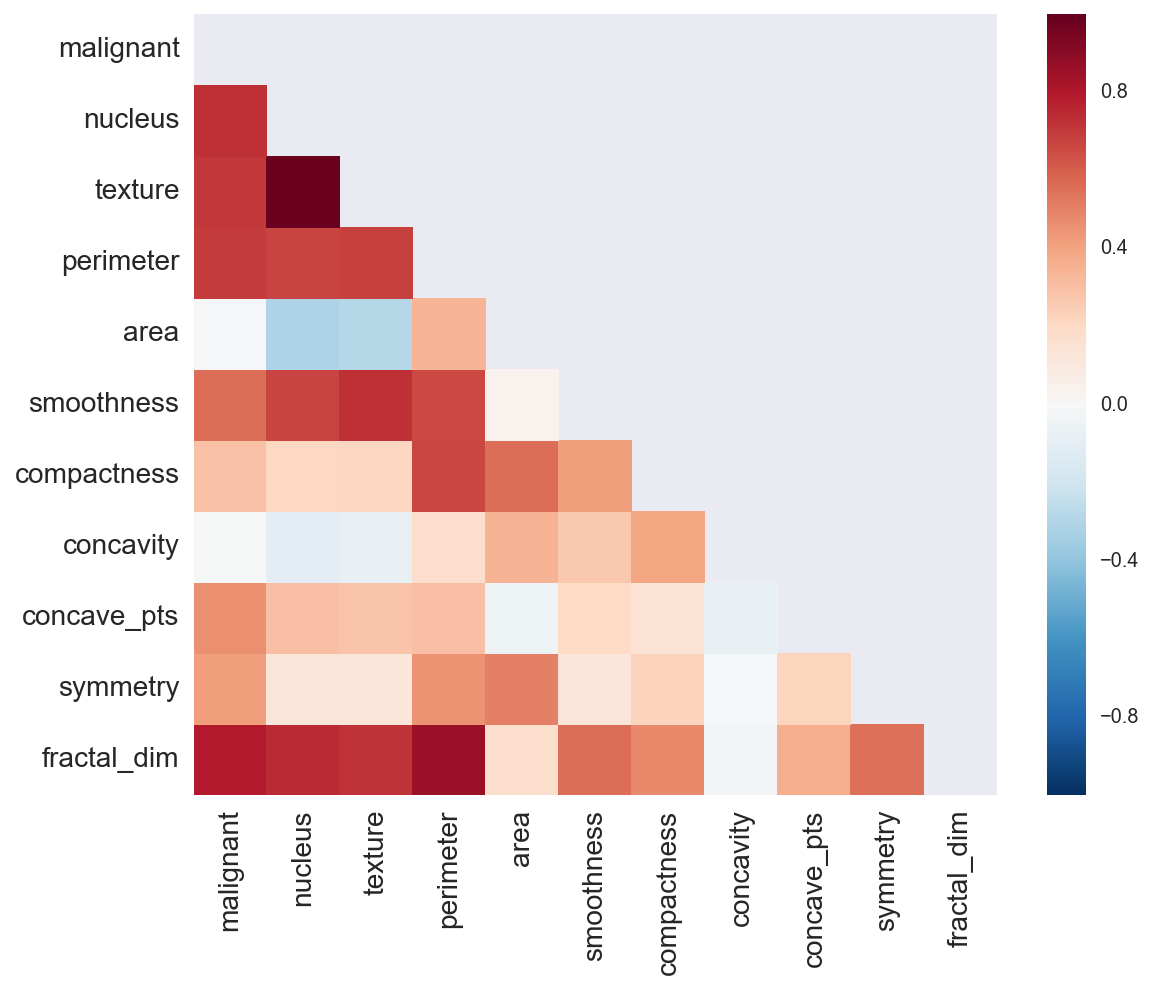

In [10]:
mean_corr = bcw_mean[[x for x in bcw_mean.columns if x not in 'id']].corr()

# Set the default matplotlib figure size:
plt.rcParams['figure.figsize']=(9,7)

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(mean_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(mean_corr, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

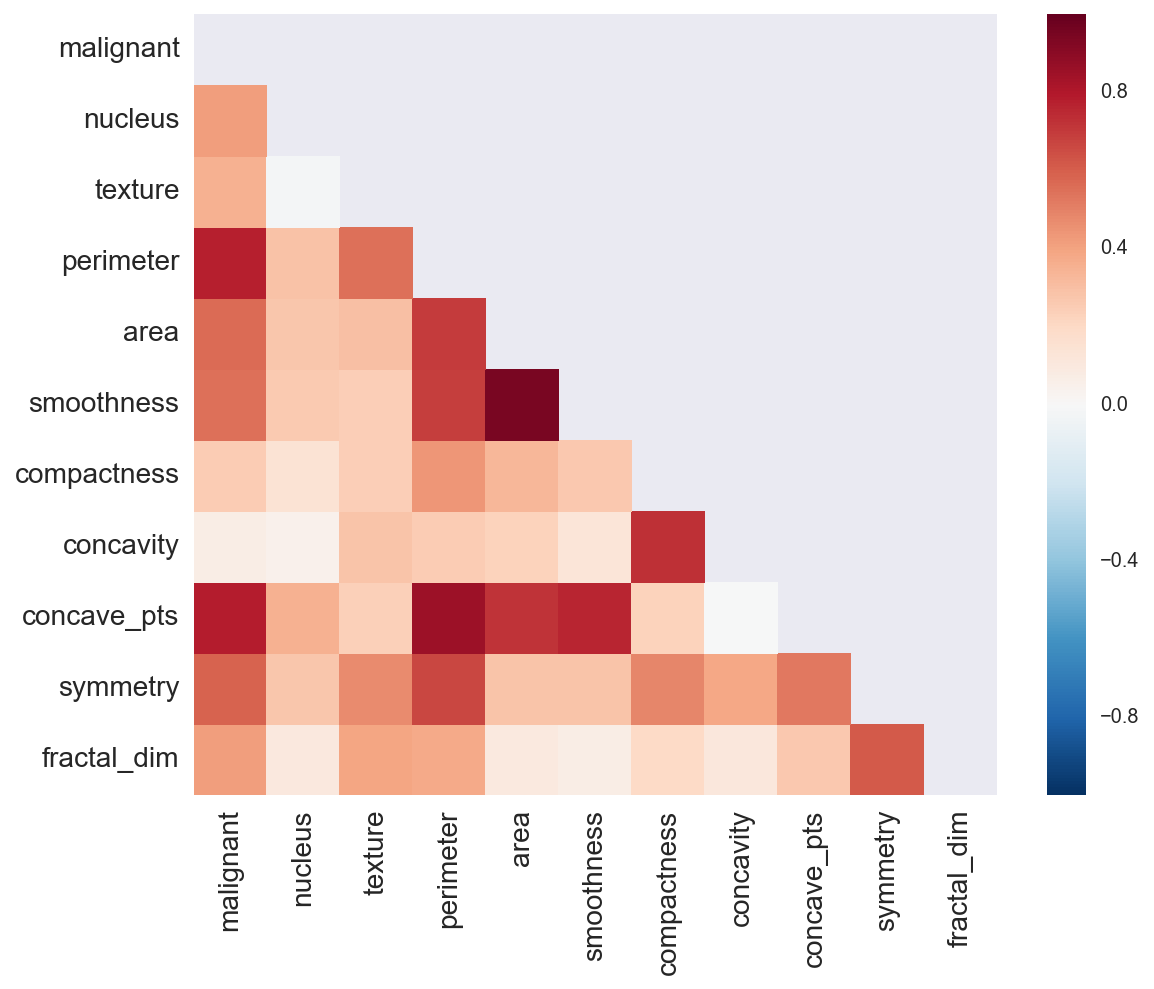

In [11]:
se_corr = bcw_se[[x for x in bcw_se.columns if x not in 'id']].corr()

# Set the default matplotlib figure size:
plt.rcParams['figure.figsize']=(9,7)

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(se_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(se_corr, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

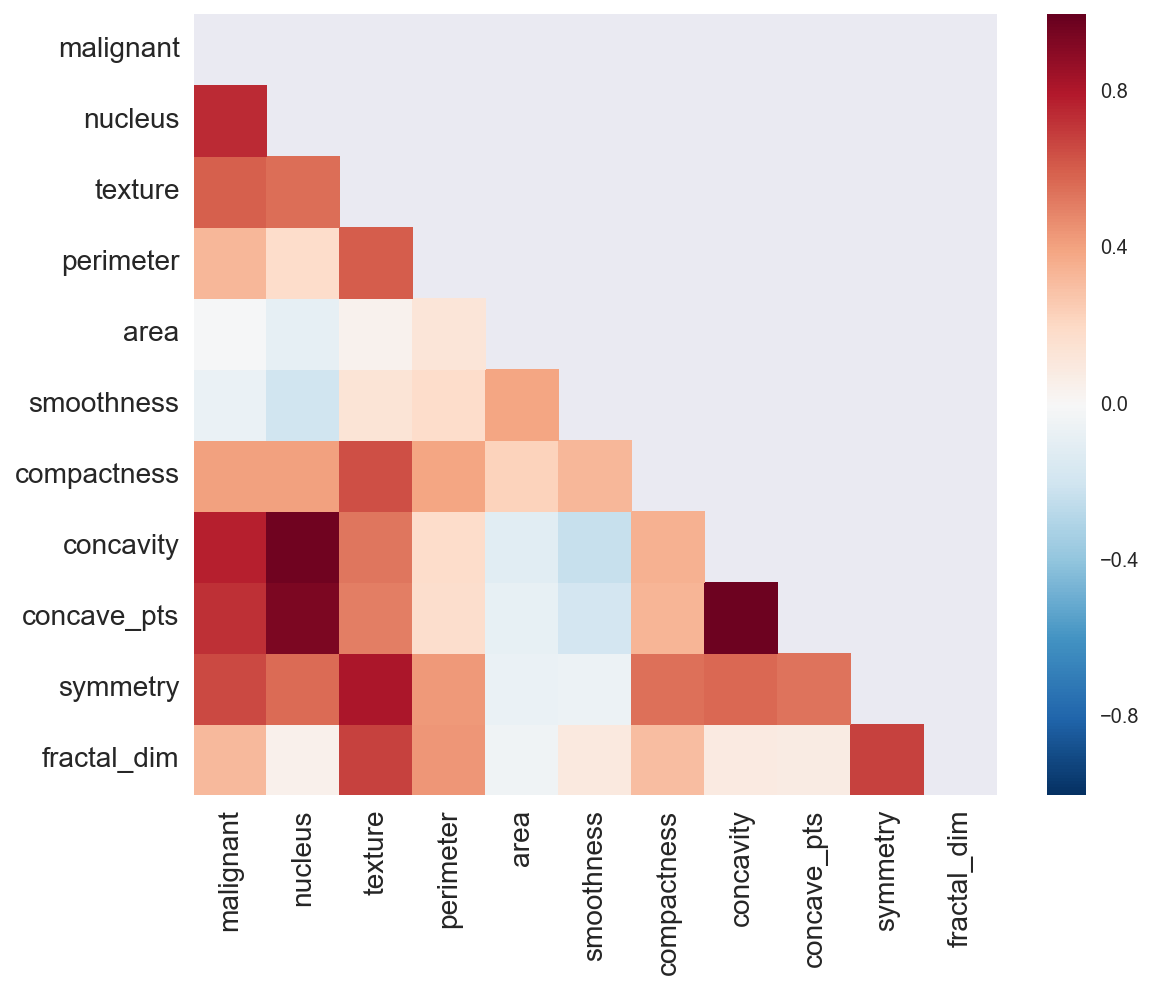

In [12]:
worst_corr = bcw_worst[[x for x in bcw_worst.columns if x not in 'id']].corr()

# Set the default matplotlib figure size:
plt.rcParams['figure.figsize']=(9,7)

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(worst_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(worst_corr, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

---

### 3.2 Look at correlations between mean, standard error, and worst within variable

Look at the correlations between each single variables mean, se, and worst value:

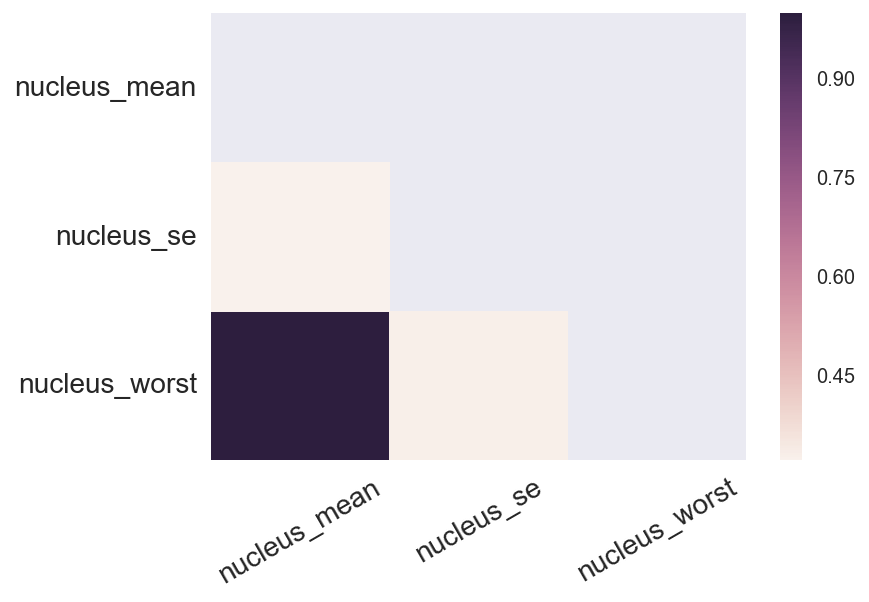

--------------------------------------------



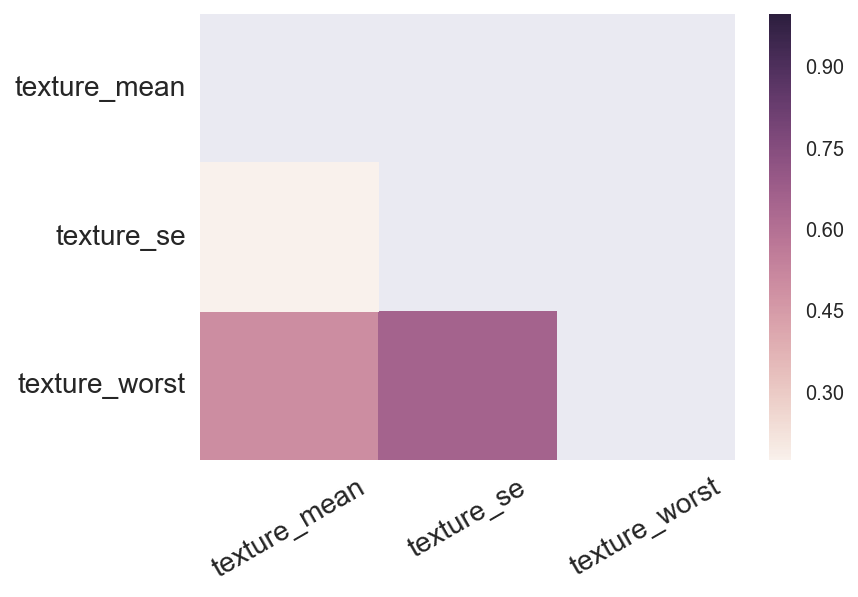

--------------------------------------------



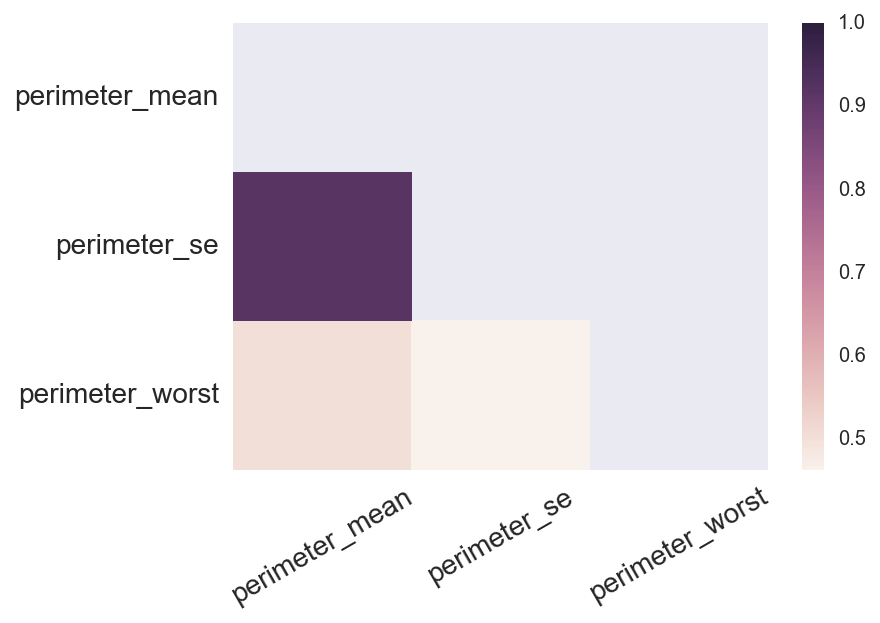

--------------------------------------------



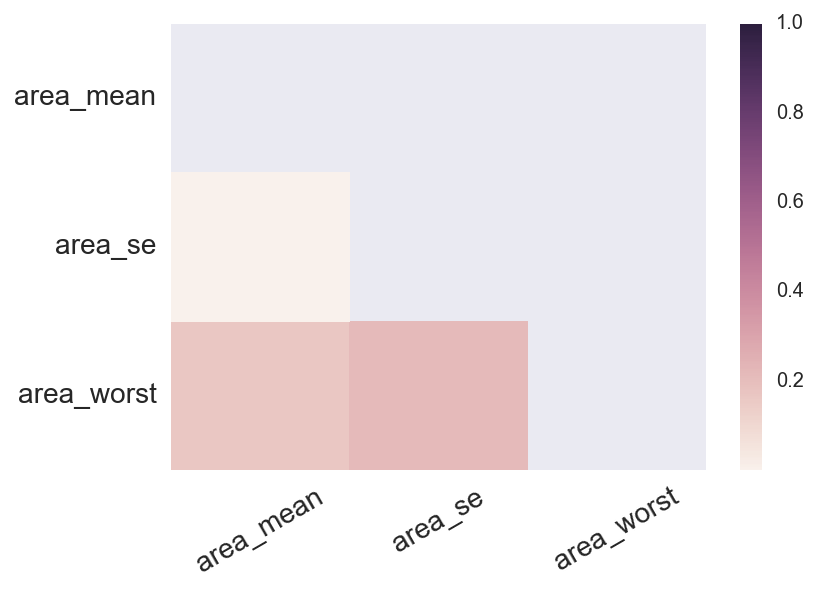

--------------------------------------------



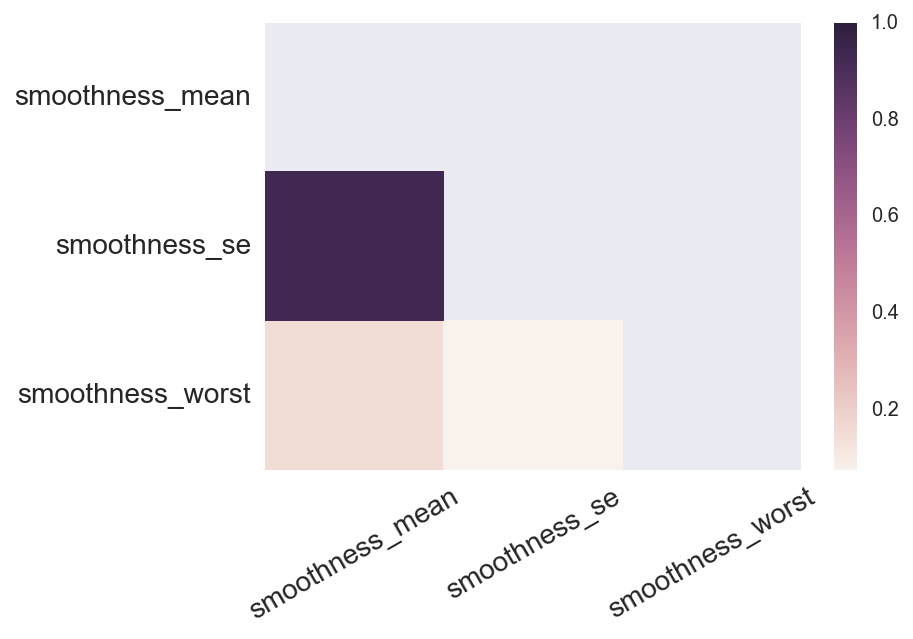

--------------------------------------------



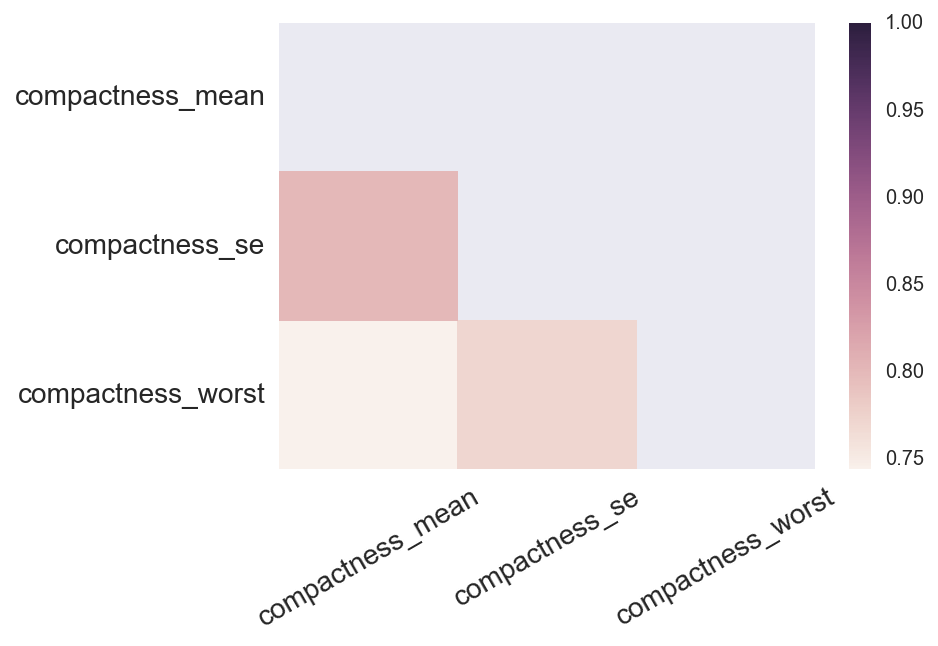

--------------------------------------------



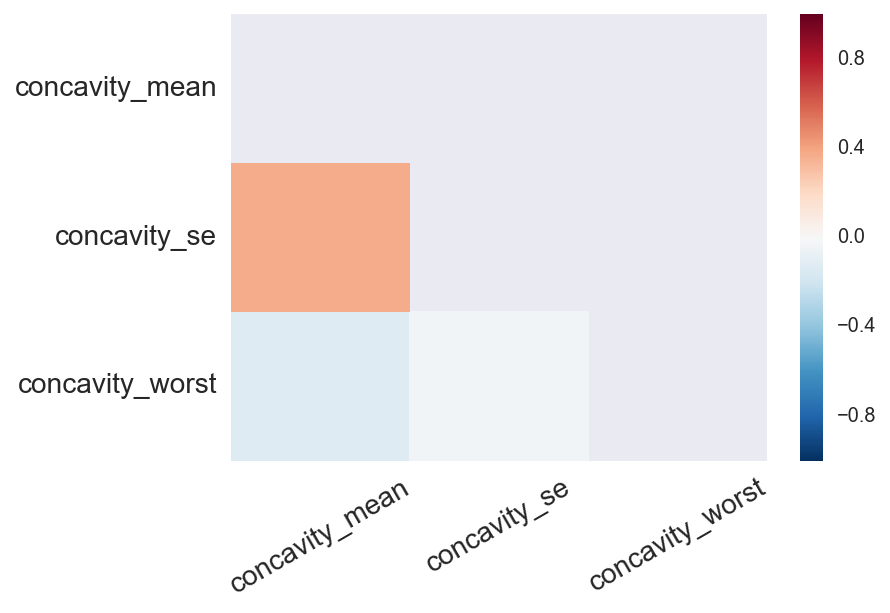

--------------------------------------------



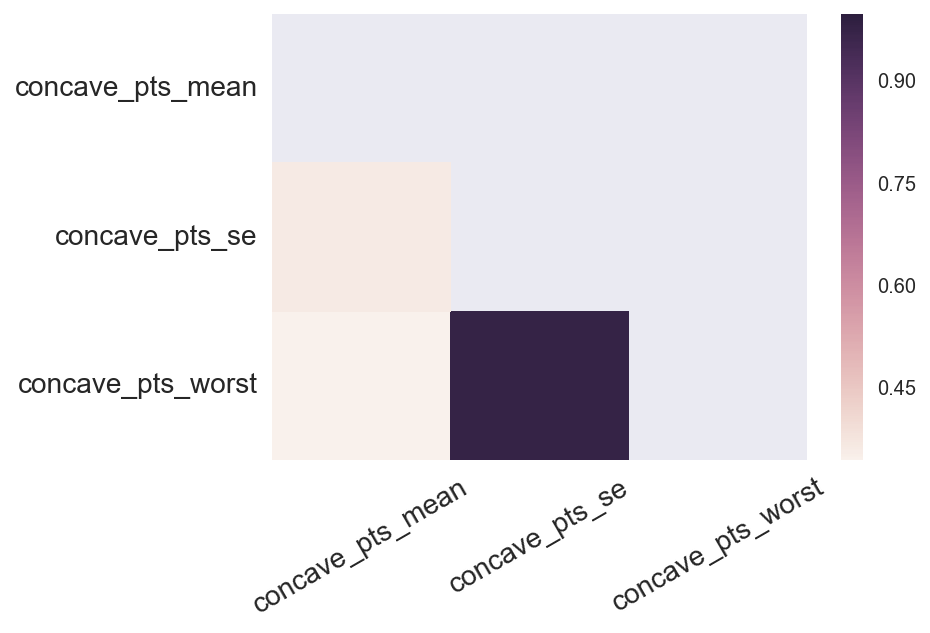

--------------------------------------------



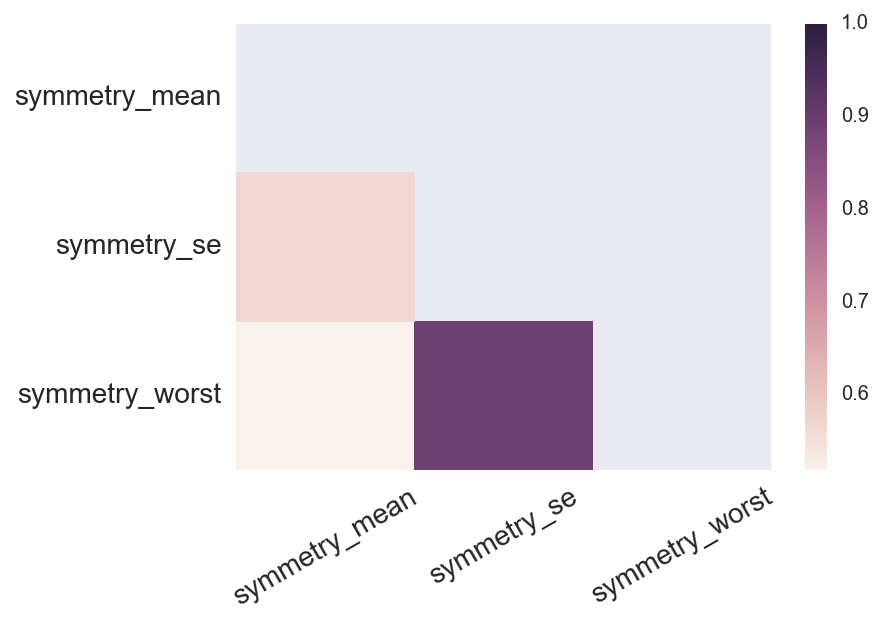

--------------------------------------------



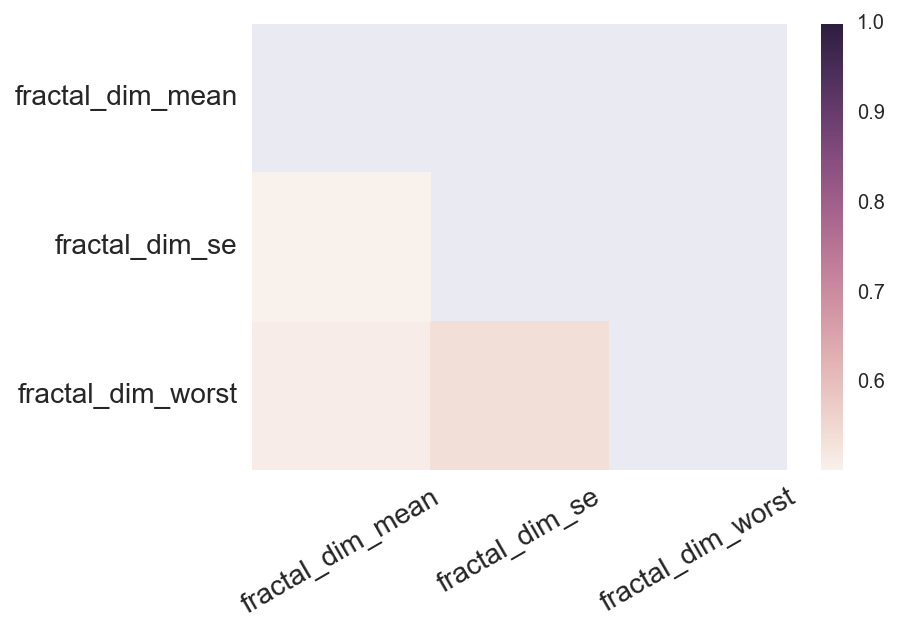

--------------------------------------------



In [13]:
# A function that prints the variable name, subsets the data to just
# be columns that have those variable names, and print out the
# correlation between the variables
def variable_corr_heatmapper(df, varname):
    var_corr = df[[x for x in df.columns if varname in x]].corr()
    
    plt.rcParams['figure.figsize']=(6,4)
    
    mask = np.zeros_like(var_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    ax = sns.heatmap(var_corr, mask=mask)
    
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)
    plt.show()
    print '--------------------------------------------\n'

# get the variable names without the _mean, _se, _worst suffixes and
# remove duplicate names by filtering
varnames = [
    x.replace('_mean','')
    for x in bcw.columns
    if x not in ['id','malignant']
    and '_se' not in x
    and '_worst' not in x
]

for var in varnames:
    variable_corr_heatmapper(bcw, var)

---

### 4. Use seaborn's pairplot to visualize relationships between variables

Look at the data using seaborn's `pairplot()` function. The hue will be the class variable "malignant". The variables will be the other columns excluding, of course, the subject ID column.

Most of these predictors are highly correlated with the "class" variable. This is already an indication that our classifier is very likely to perform well.

In [14]:
# set the seaborn style to have a white background
sns.set(style="ticks", color_codes=True)

# This function does a pairplot across your variables with the color
# set as the outcome "malignant" class variable
def bcw_pairplotter(df, variables, sample_frac=0.3):
    # sample_frac lets you specify an amount of the data to sample for the plot.
    # this speeds up the function which can take awhile with the full data.
    
    # get the number of rows/data points:
    rows = df.shape[0]
    
    # get downsample indicies for the data, if specified
    if sample_frac < 1.0:
        sample_inds = np.random.choice(range(0,rows), 
                                       size=int(round(rows*sample_frac)), 
                                       replace=False).astype(int)
    
    # make the pairplot for the variables:
    pairs = sns.pairplot(df.iloc[sample_inds, :], 
                         vars=variables, 
                         hue="malignant", 
                         palette=sns.xkcd_palette(['windows blue', 'amber']))


# get out the column variable names to put into the pairplotter function
colvars = [x for x in bcw_mean if x not in ['id','malignant']]

---

### 4.2 Plot the mean data subset with the pairplotter function

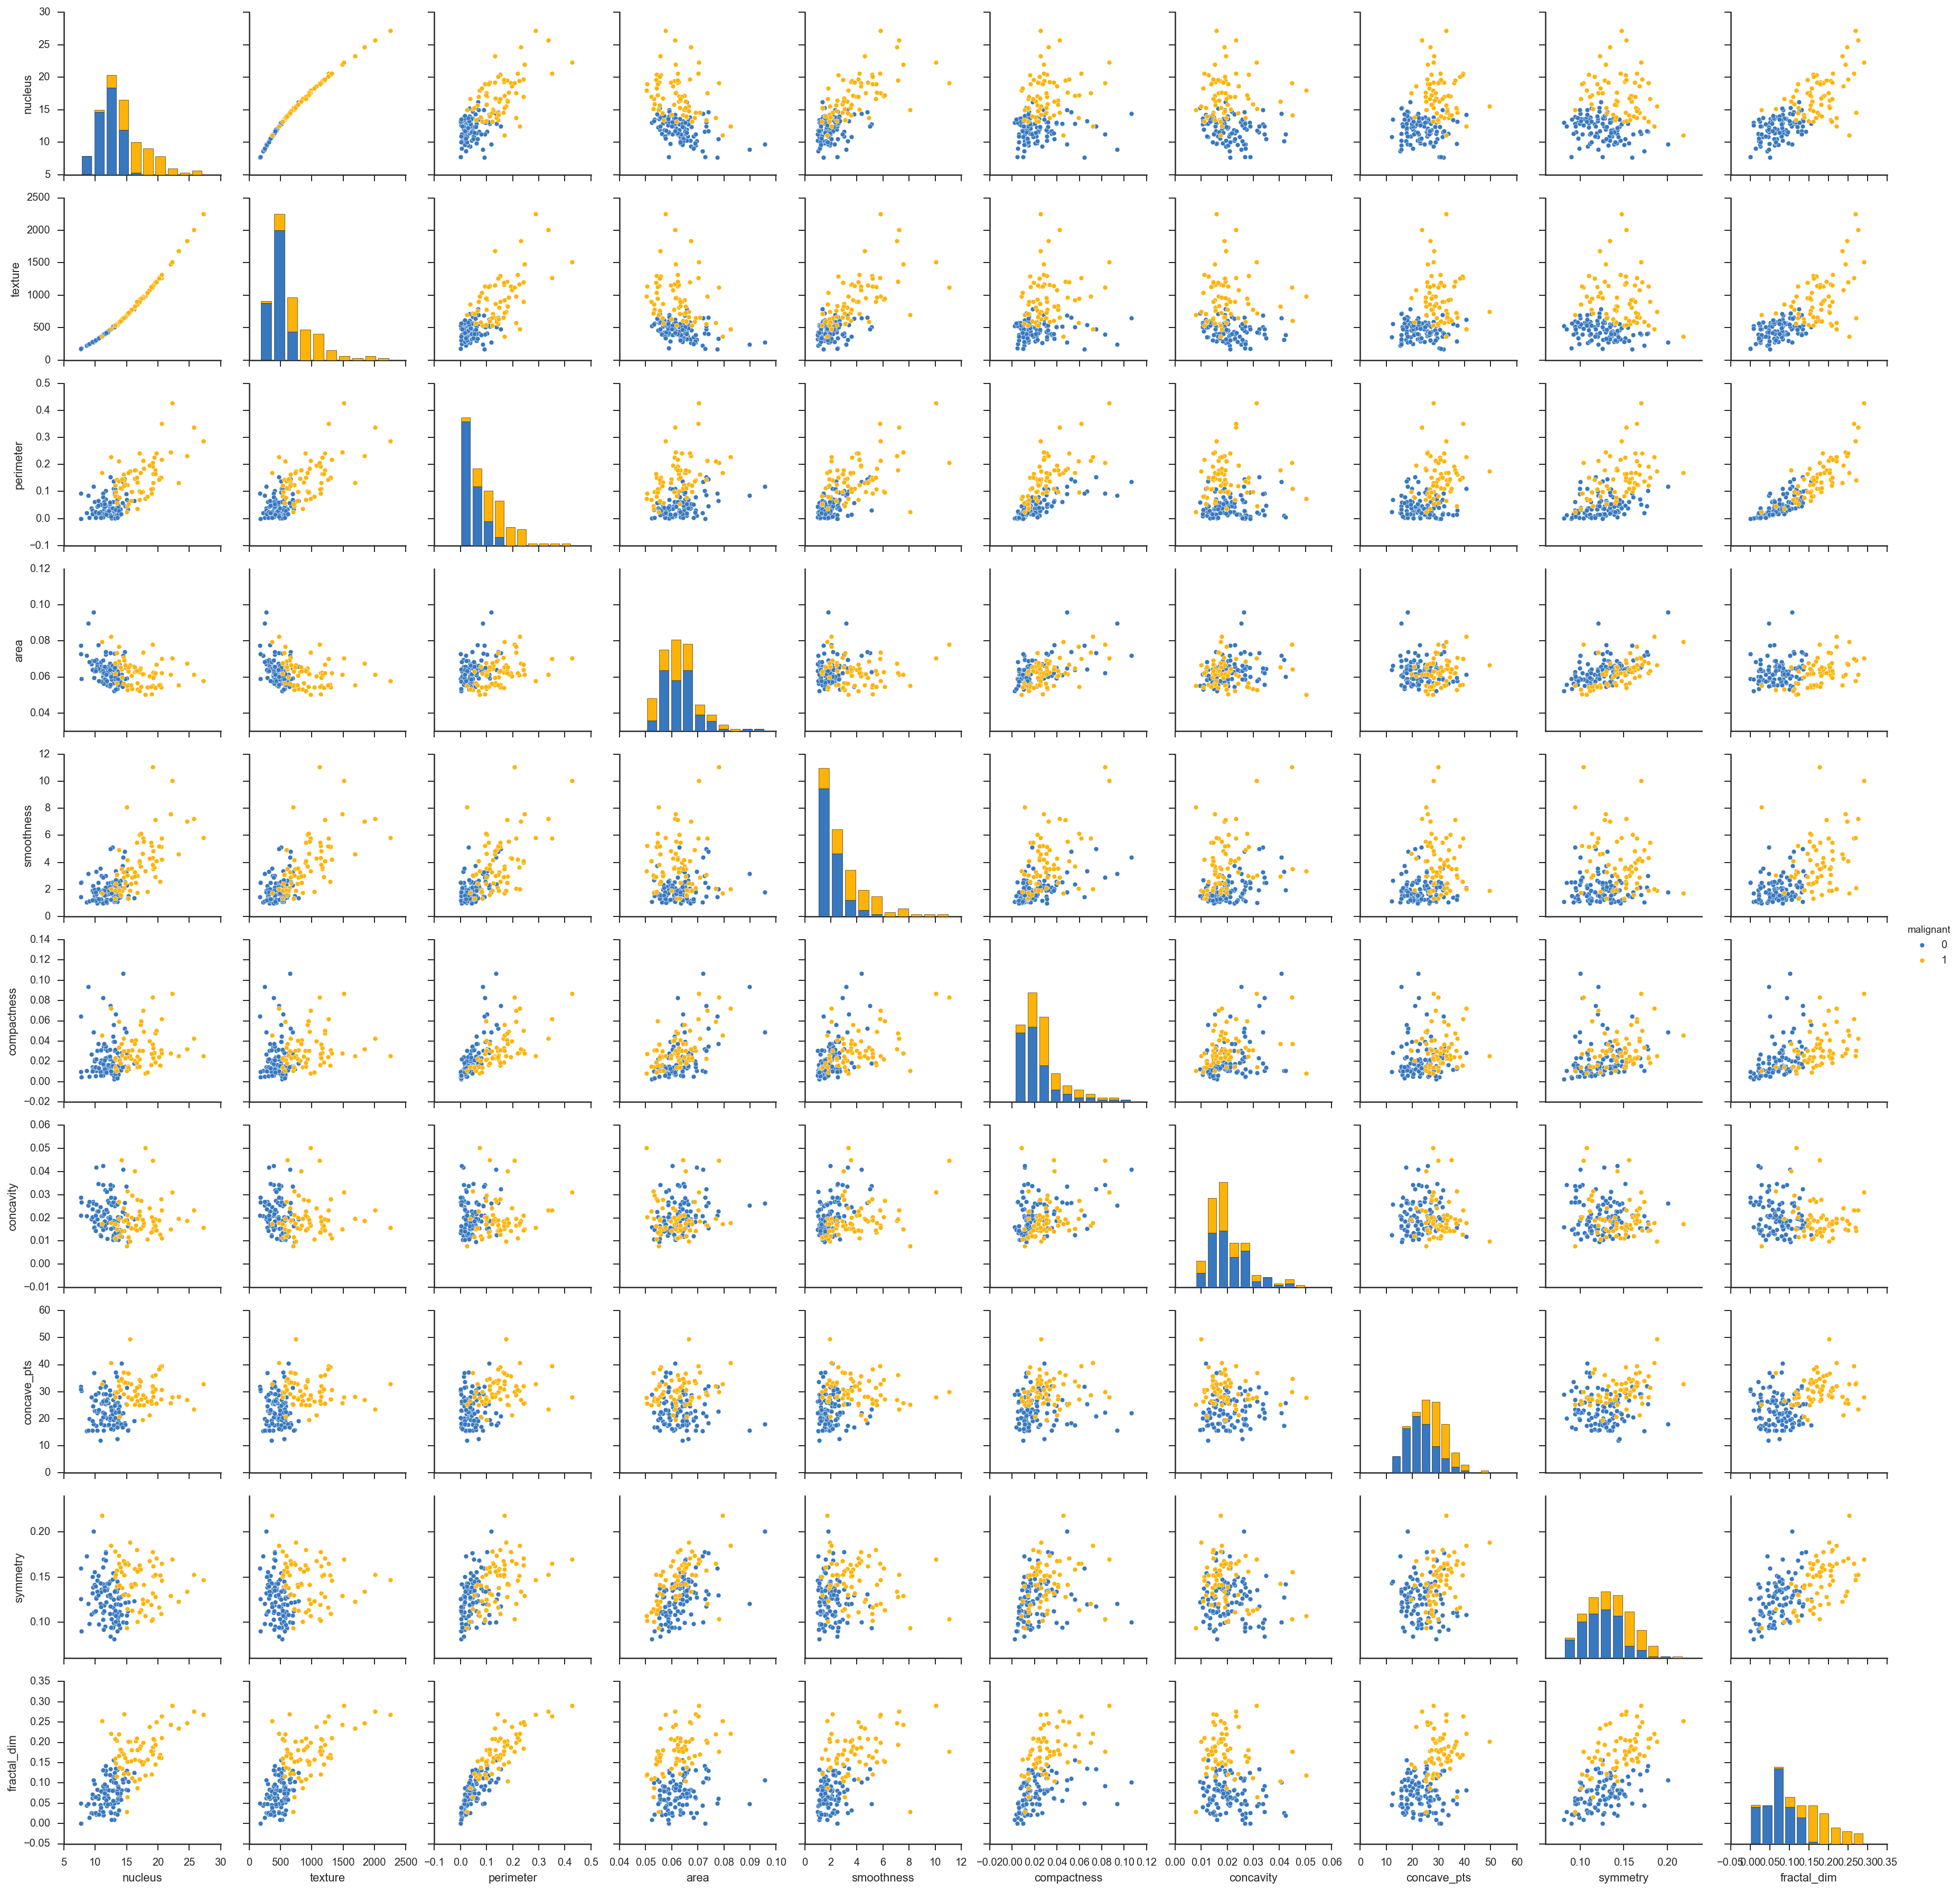

In [15]:
bcw_pairplotter(bcw_mean, colvars)

---

### 4.3 Plot the standard error data subset with the pairplotter function

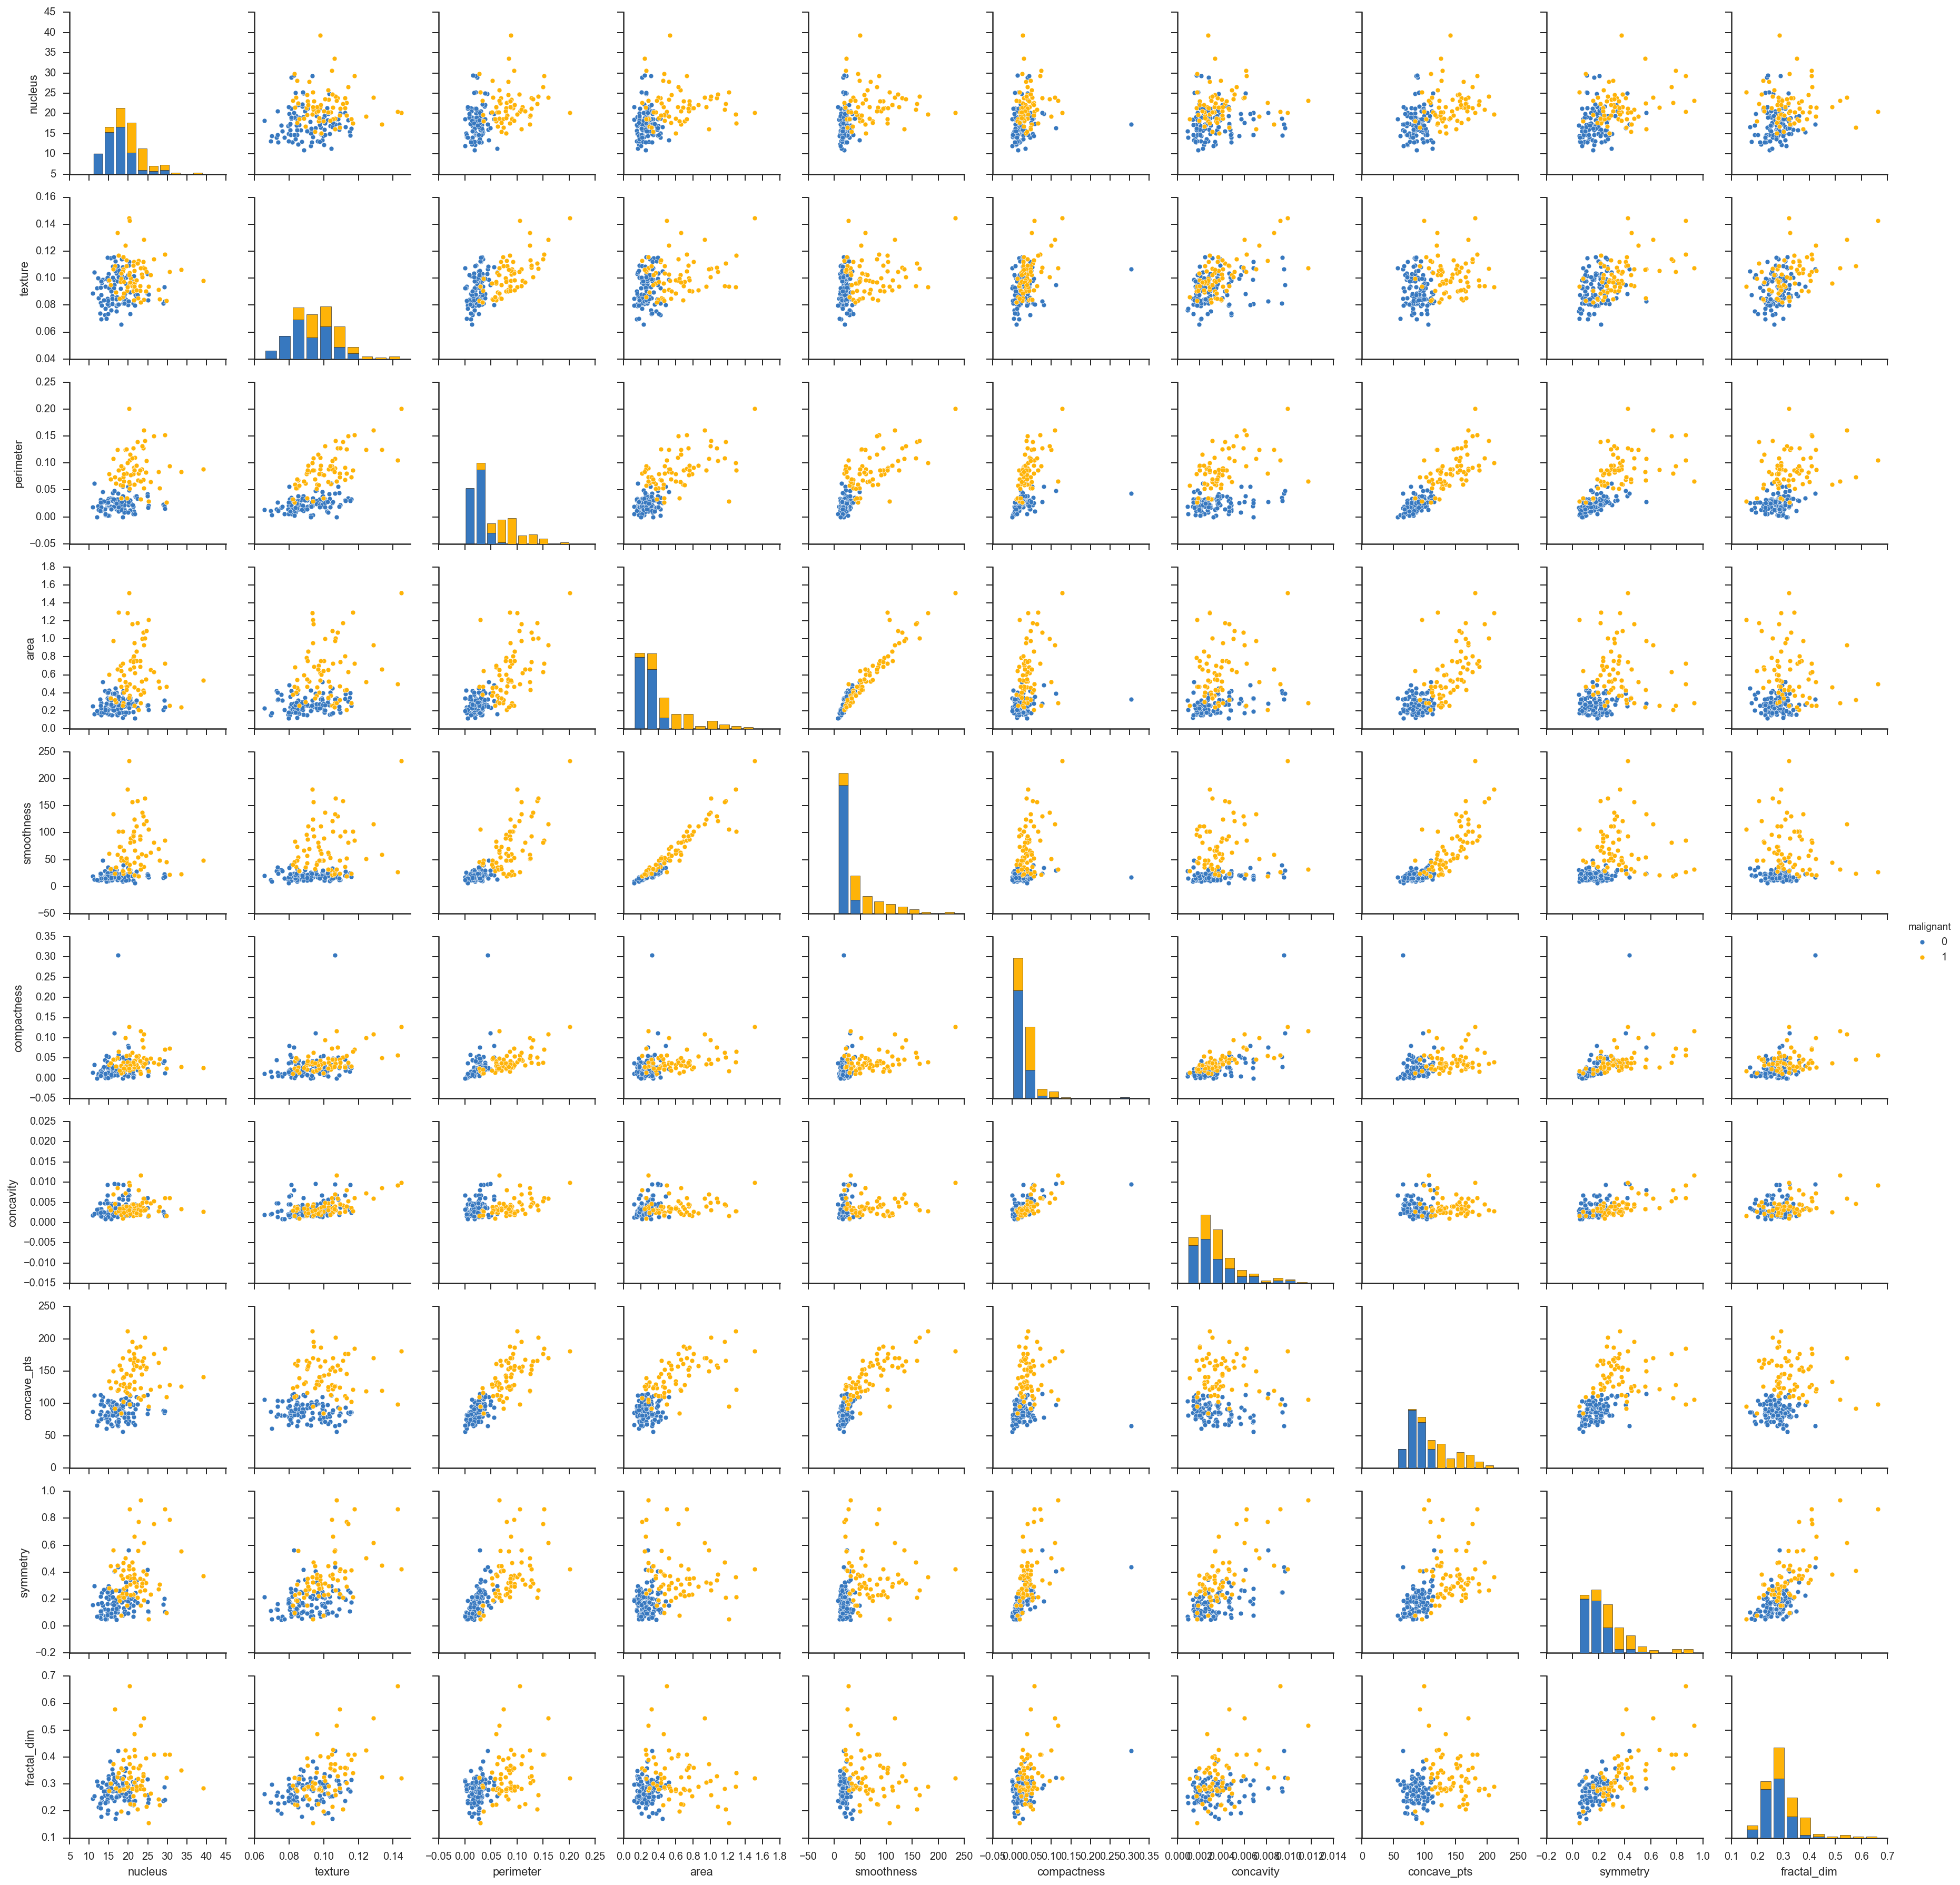

In [ ]:
bcw_pairplotter(bcw_se, colvars)

---

### 4.4 Plot the worst value data subset using the pairplotter function

In [ ]:
bcw_pairplotter(bcw_worst, colvars)

---

### 5. Test the performance of kNN classifiers on the data using cross-validation

Let's see how the kNN classifier performs on the dataset with cross-validation.

We are going to set some parameters in the classifier constructor. Some clarification below:

1. **n_neighbors** specifies how many neighbors will vote on the class
2. **weights** uniform weights indicate that all neighbors have the same weight
3. **metric** and **p**: when distance is minkowski (the default) and p == 2 (the default), _this is equivalent to the euclidean distance metric_

Load scikit's cross-validation module and import `StratifiedKFold`

The `StratifiedKFold()` will return cross-validation _indices_ which you can use to subset your data in a for loop that runs the model and tests it. Get used to using indices for cross-validation on data – it's easy to get soft with `cross_val_score`, but being able do it at a more "manual" level allows for a lot more power and customization. It also reinforces what is happening in your head during cross-validation, since you have to divide up the data yourself with the indices!

The **stratified** version of cross-validation ensures that there are equal proportions the predicted class in each train-test fold. This is going to be a common practice in classification.

In [ ]:
from sklearn.cross_validation import StratifiedKFold

**Create X, y from the "mean" variables data:**

In [ ]:
y = bcw_mean['malignant'].values
X = bcw_mean[colvars].values


**Create cross-validation train/test indices:**

In [ ]:
cv_indices = StratifiedKFold(y, n_folds=5)

In [ ]:
# Function to crossvalidate accuracy of a knn model acros folds
def accuracy_crossvalidator(X, Y, knn, cv_indices):
    
    # list to store the scores/accuracy of folds
    scores = []
    
    # iterate through the training and testing folds in cv_indices
    for train_i, test_i in cv_indices:
        
        # get the current X train & test subsets of X
        X_train = X[train_i, :]
        X_test = X[test_i, :]

        # get the Y train & test subsets of Y
        Y_train = Y[train_i]
        Y_test = Y[test_i]

        # fit the knn model on the training data
        knn.fit(X_train, Y_train)
        
        # get the accuracy predicting the testing data
        acc = knn.score(X_test, Y_test)
        scores.append(acc)
        
        print('Fold accuracy:', acc)
        
    print('Mean CV accuracy:', np.mean(scores))


---

### 5.2: Cross-validate accuracy for a kNN model with 5 neighbors on the mean data subset

In [ ]:
mean_knn_n5 = KNeighborsClassifier(n_neighbors=5,
                                   weights='uniform')

accuracy_crossvalidator(X, y, mean_knn_n5, cv_indices)

---

### 5.3: Cross-validate accuracy for a kNN model with 1 neighbor on the mean data subset

As you can see the mean cross-validated accuracy is very high with 5 neighbors. 

Let's see what it's like when we use only 1 neighbor:

In [ ]:
mean_knn_n2 = KNeighborsClassifier(n_neighbors=1,
                              weights='uniform')

accuracy_crossvalidator(X, y, mean_knn_n2, cv_indices)

---

### 5.4 Cross-validate accuracy for a kNN model with 5 neighbors on the standard error subset

In [ ]:
y = bcw_se['malignant'].values
X = bcw_se[colvars].values

se_knn_n2 = KNeighborsClassifier(n_neighbors=5,
                                 weights='uniform')

accuracy_crossvalidator(X, y, se_knn_n2, cv_indices)

---

### 5.5 Cross-validate accuracy for a kNN model with 5 neighbors on the worst value subset

In [ ]:
y = bcw_worst['malignant'].values
X = bcw_worst[colvars].values

worst_knn_n5 = KNeighborsClassifier(n_neighbors=5,
                                    weights='uniform')

accuracy_crossvalidator(X, y, worst_knn_n5, cv_indices)

---

### 6. Plot the kNN prediction boundary

Even with 1 neighbor we do quite well at predicting the malignant observations.

Below you can load an interactive KNN visualization class I wrote and put in your new `utils` directory.

The `KNNBoundaryPlotter` class has 4 required arguments:

    KNNBoundaryPlotter(data, predictor1, predictor2, class_target)
    
It will by default fit a visualization of the decision boundary across 1 to 100 nearest neighbors.

The boundary is where the classifier will vote for malignant vs. benign classes. 


In [ ]:
import imp
plotter = imp.load_source('plotter', '/Users/kiefer/github-repos/DSI-SF-2/utils/plotting/knn_plotter.py')
from plotter import KNNBoundaryPlotter

kbp = KNNBoundaryPlotter(bcw_mean, 'area', 'symmetry', 'malignant', nn_range=range(1,101))

kbp.knn_mesh_runner()

kbp.knn_interact()

--- 

### 6.2 Try out some other variables of interest to you with the visualization class

---

### 7. What is the effect of increasing/decreasing the neighbors?

In [ ]:
#

---

### 8 What could be wrong with using accuracy as your measure of performance?

In [ ]:
#

---

### 9. Explain changing the number of neighbors in terms of bias-variance tradeoff

In [ ]:
#